# Face Generation with Convolutional VAE

This notebook implements a convolutional variational autoencoder (VAE) trained on the CelebA face dataset using PyTorch.

It uses convolutional layers to encode and decode 64x64 face images, and demonstrates generation by sampling from the latent space.

In [ ]:
!pip install torch torchvision matplotlib

In [5]:
# Enable autoreloading in Jupyter (if applicable)
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm  # Used for visualizing latent distributions

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, utils

In [30]:
# Hyperparameters

IMAGE_SIZE = 32        # Input image resolution (32x32)
CHANNELS = 3           # Number of color channels (RGB)
BATCH_SIZE = 128       # Batch size for training
NUM_FEATURES = 128     # Hidden layer size or intermediate feature size
Z_DIM = 200            # Dimensionality of the latent space
LEARNING_RATE = 5e-4   # Learning rate for optimizer
EPOCHS = 1             # Number of training epochs
BETA = 2000            # Weight for KL divergence term in loss (used in beta-VAE)

## Loading and Preprocessing the CelebA Dataset

In [17]:
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader

# Transform pipeline: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load CelebA dataset
train_data = CelebA(
    root="./data",                      # Where to download/save the data
    split="train",                      # Options: "train", "valid", "test", or "all"
    download=True,                      # Download if not already there
    transform=transform
)

# DataLoader
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


val_data = CelebA(
    root="./data",
    split="valid",
    download=True,
    transform=transform
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Visualizing Training Data

In [18]:
def sample_batch(dataloader, num_samples=16):
    """
    Sample one batch from the dataloader and return the first `num_samples` images.
    """
    for images, _ in dataloader:
        return images[:num_samples]

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def display(images, cmap=None, nrow=8):
    """
    Display a grid of images using matplotlib.
    """
    grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
    np_img = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.imshow(np_img, cmap=cmap)
    plt.axis('off')
    plt.show()

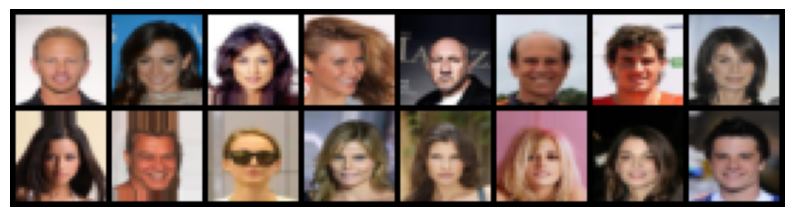

In [11]:
train_sample = sample_batch(train_loader, num_samples=16)
display(train_sample)

## Reparameterization Trick

In [20]:
def reparameterize(z_mean, z_log_var):
    """
    Reparameterization trick: z = mu + sigma * epsilon
    where epsilon ~ N(0, I)
    """
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

## Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),  # 8 → 4
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),  # 4 → 2
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),
        )

        self.flatten = nn.Flatten()
        self.feature_shape = (NUM_FEATURES, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        self.flat_dim = NUM_FEATURES * (IMAGE_SIZE // 16) ** 2

        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)

    def forward(self, x):
        x = self.conv(x)
        x_flat = self.flatten(x)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        return mu, logvar

# Decoder

In [22]:
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.feature_shape = (NUM_FEATURES, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        self.fc = nn.Sequential(
            nn.Linear(z_dim, np.prod(self.feature_shape)),
            nn.BatchNorm1d(np.prod(self.feature_shape)),
            nn.LeakyReLU()
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, *self.feature_shape)
        x = self.deconv(x)
        return x

## VAE Model Wrapper: Encoder, Reparameterization, and Decoder

In [23]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        """
        z = mu + sigma * epsilon
        where epsilon ~ N(0, I)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """
        Forward pass:
        - Encode input to get mu and logvar
        - Sample z using reparameterization trick
        - Decode z to reconstruct image
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

## VAE Loss

In [24]:
def vae_loss(x, x_recon, mu, logvar, beta=BETA):
    """
    VAE loss = beta * reconstruction loss (MSE) + KL divergence
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_recon, x, reduction='mean') * beta

    # KL divergence between q(z|x) and N(0, I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # average over batch

    return recon_loss + kl_loss, recon_loss, kl_loss

## Generating and Saving Sample Images from the Latent Space

In [25]:
from torchvision.utils import save_image
import os

def generate_images(model, epoch, z_dim, num_img=8, path="./output"):
    """
    Generate and save images from random latent vectors after each epoch.
    """
    os.makedirs(path, exist_ok=True)
    model.eval()
    z = torch.randn(num_img, z_dim).to(next(model.parameters()).device)
    with torch.no_grad():
        generated = model.decoder(z)
    for i in range(num_img):
        save_image(generated[i], f"{path}/generated_img_{epoch:03d}_{i}.png")

## Save Checkpoint

In [26]:
def save_checkpoint(model, epoch, loss, best_loss, path="./checkpoint.pt"):
    if loss < best_loss:
        print(f"Saving new best model at epoch {epoch} with loss {loss:.4f}")
        torch.save(model.state_dict(), path)
        return loss
    return best_loss

## Training Step

In [27]:
def train_step(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for batch in dataloader:
        x, _ = batch if isinstance(batch, (tuple, list)) else (batch, None)
        x = x.to(device)

        optimizer.zero_grad()

        x_recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(x, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    num_batches = len(dataloader)
    return {
        "loss": total_loss / num_batches,
        "reconstruction_loss": total_recon / num_batches,
        "kl_loss": total_kl / num_batches
    }

## Validation Step

In [28]:
@torch.no_grad()
def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for batch in dataloader:
        x, _ = batch if isinstance(batch, (tuple, list)) else (batch, None)
        x = x.to(device)
        x_recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(x, x_recon, mu, logvar)
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    num_batches = len(dataloader)
    return {
        "loss": total_loss / num_batches,
        "reconstruction_loss": total_recon / num_batches,
        "kl_loss": total_kl / num_batches
    }

## Instantiate model, optimizer, writer, device

In [29]:
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(z_dim=Z_DIM)
decoder = Decoder(z_dim=Z_DIM)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

writer = SummaryWriter(log_dir="./logs")

## Training the VAE Model

In [31]:
best_loss = float("inf")

for epoch in range(EPOCHS):
    train_logs = train_step(vae, train_loader, optimizer, device)
    val_logs = validate_epoch(vae, val_loader, device)

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_logs['loss']:.4f} | "
          f"Val Loss: {val_logs['loss']:.4f}")

    # Save best model
    best_loss = save_checkpoint(vae, epoch, val_logs["loss"], best_loss)

    # Generate and save sample images
    generate_images(vae, epoch, Z_DIM)

    # Log to TensorBoard
    writer.add_scalar("Loss/train", train_logs["loss"], epoch)
    writer.add_scalar("Loss/val", val_logs["loss"], epoch)
    writer.add_scalar("KL/train", train_logs["kl_loss"], epoch)
    writer.add_scalar("Recon/train", train_logs["reconstruction_loss"], epoch)

Epoch 01 | Train Loss: 72.4671 | Val Loss: 58.4050
Saving new best model at epoch 0 with loss 58.4050


## Reconstruct using the variational autoencoder

Example real faces


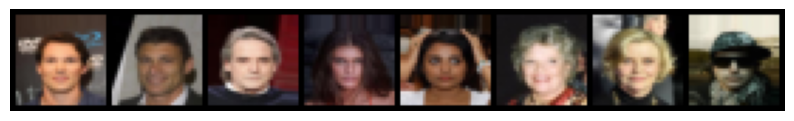

Reconstructions


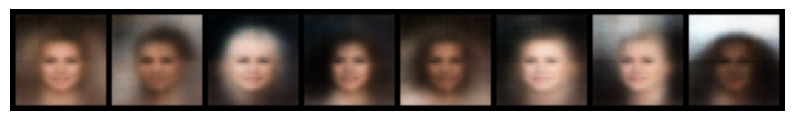

In [32]:
# Select a batch of images from the training set
example_images, _ = next(iter(train_loader))  # Ignore labels
example_images = example_images[:8].to(device)  # Select first 8 images

# Set model to evaluation mode
vae.eval()

# Forward pass through the VAE to get reconstructions
with torch.no_grad():
    reconstructions, _, _ = vae(example_images)

# Move tensors to CPU for display
example_images = example_images.cpu()
reconstructions = reconstructions.cpu()

# Display original images
print("Example real faces")
display(example_images)

# Display reconstructed images
print("Reconstructions")
display(reconstructions)

## Generate New Faces

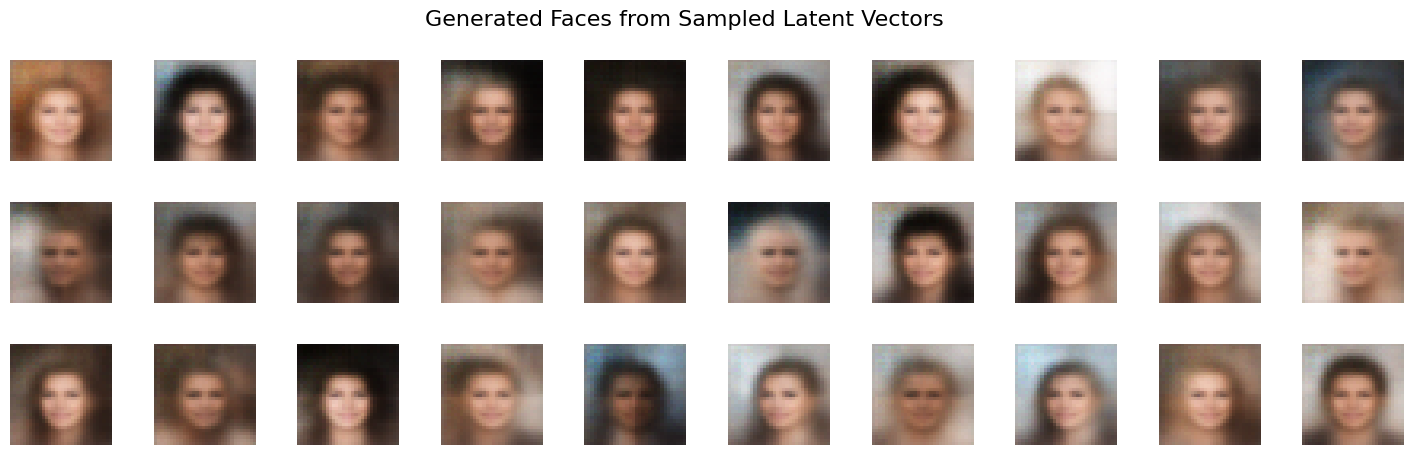

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Sample latent vectors from standard normal distribution
grid_width, grid_height = 10, 3
num_samples = grid_width * grid_height
z_sample = torch.randn(num_samples, Z_DIM).to(device)

# Decode to generate new faces
vae.eval()
with torch.no_grad():
    generated_faces = vae.decoder(z_sample).cpu()  # Shape: [N, C, H, W]

# Plot grid of generated images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(num_samples):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    img = generated_faces[i].permute(1, 2, 0).numpy()  # CHW → HWC
    ax.imshow(img)

plt.suptitle("Generated Faces from Sampled Latent Vectors", fontsize=16)
plt.show()